Make ref pix figure where mountains are one color, LS is another color, and rest of pixels are either ref pix (white?) or not (black?) and also try pixel density and see if that displays better. 

Created 7-25-23. 

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM.

In [2]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)

print('DEM loaded.')

DEM loaded.


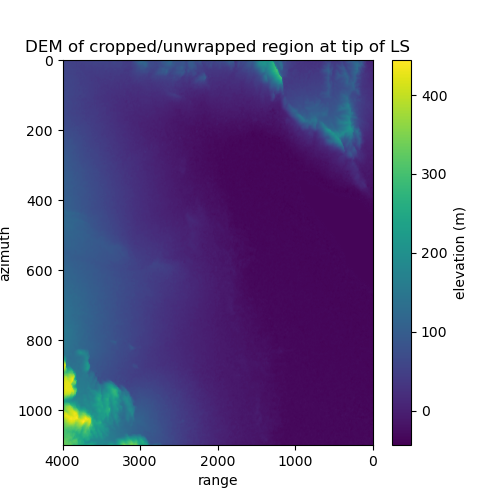

In [3]:
# Extract subregion that was unwrapped full res and plot it [larger box with western mtns]
box = np.zeros((5,2))
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]


plt.figure(figsize=(5,5))
plt.imshow(elev_cropped, cmap='viridis',aspect='auto',interpolation='nearest')
plt.xlim(x1-x2, 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('DEM of cropped/unwrapped region at tip of LS')
plt.colorbar(label='elevation (m)')
plt.show()

Find mountain pixels that I exclude from reference region.

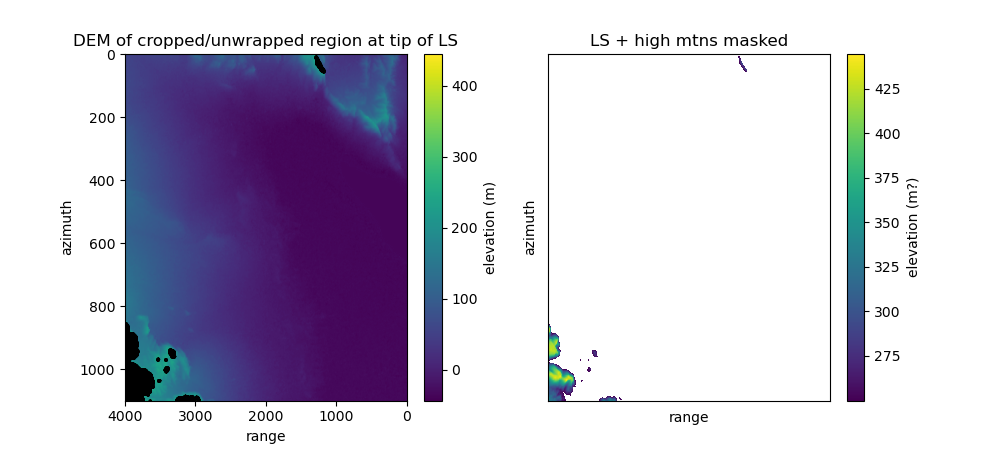

In [4]:
# For LARGER cropped area with western mountains, we need different criteria for opposite mtns. 
dy = y1-y2; dx = x1-x2
elev_ref_region = np.ones((dy,dx))
for y in range(dy):
    for x in range(dx):
        # if (x*-0.275+1100 > y) : # top right geographically 
        #     if (elev_cropped[y,x] < 75):
        #         elev_ref_region[y,x] = 0
        # else: # bottom left geographically 
        #     if (elev_cropped[y,x] < 300): #300 
        #         elev_ref_region[y,x] = 0
        if ((elev_cropped[y,x] < 250)):
            elev_ref_region[y,x] = 0
# find pixel location of these mountain pixels. 
mtns_y,mtns_x = np.nonzero(elev_ref_region)
# larger area with western mtns 
elev_masked = np.ma.masked_where(elev_ref_region==0,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',aspect='auto',interpolation='none')
plt.xlim(x1-x2, 0)
plt.plot(mtns_x,mtns_y,'k.',ms=0.5)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('DEM of cropped/unwrapped region at tip of LS')
plt.colorbar(label='elevation (m)')
plt.subplot(1,2,2)
plt.imshow(elev_masked, cmap='viridis',aspect='auto',interpolation='none'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS + high mtns masked'); plt.colorbar(label='elevation (m?)')
plt.show()

Find LS pixels that I exclude from reference pixel selection.

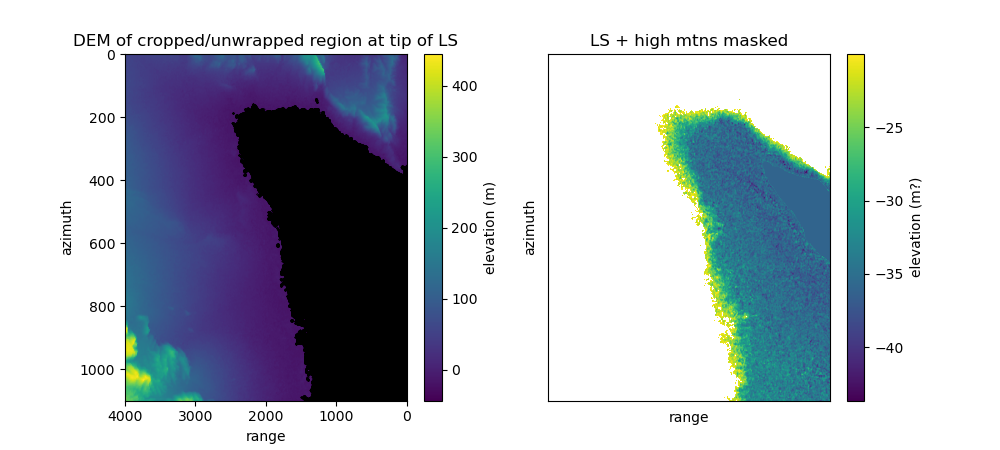

In [5]:
LS_pix = np.zeros((dy,dx))
for y in range(dy):
    for x in range(dx):
        if (elev_cropped[y,x] <= -20) : # top right geographically 
            LS_pix[y,x] = 1.0
        
# find pixel location of these mountain pixels. 
LS_y,LS_x = np.nonzero(LS_pix)
# larger area with western mtns 
elev_masked_LS = np.ma.masked_where(LS_pix==0,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',aspect='auto',interpolation='none')
plt.xlim(x1-x2, 0)
plt.plot(LS_x,LS_y,'k.',ms=0.5)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('DEM of cropped/unwrapped region at tip of LS')
plt.colorbar(label='elevation (m)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_LS, cmap='viridis',aspect='auto',interpolation='none'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS + high mtns masked'); plt.colorbar(label='elevation (m?)')
plt.show()

Now load in actual reference pixels from file.

In [6]:
loadThis = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(loadThis,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)

ref_mask_2 = np.copy(ref_mask)
# put mountains in 
ref_mask_2[mtns_y,mtns_x] = 2
ref_mask_2[LS_y,LS_x] = 3

In [7]:
import matplotlib as mpl
cmap = (mpl.colors.ListedColormap(['black', 'white', 'darkviolet', 'tan']))
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

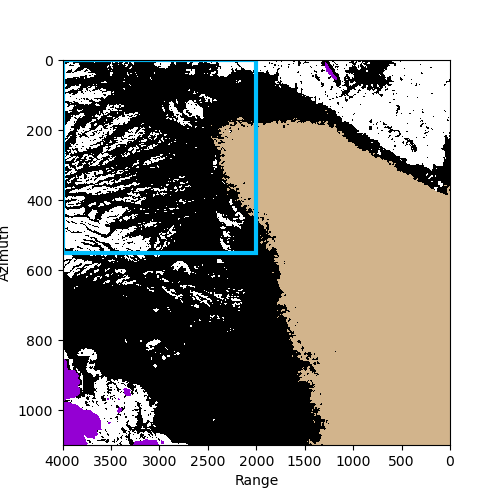

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(ref_mask_2, cmap=cmap,aspect='auto',interpolation='none') # nearest and none are the same.
plt.xlim(x1-x2, 0)
plt.xlabel('Range')
plt.ylabel('Azimuth')
#plt.title('reference pixels')
#plt.colorbar()
plt.gca().add_patch(Rectangle((2000,0),2000,550,edgecolor='deepskyblue',facecolor='none',lw=3))
plt.show()

In [9]:
# initialize array of Nans for each map.
pix_density = np.zeros((dy,dx))*np.nan
# moving window size. Same as filter size from mask_smooth function.
#alooks = 4                                  # amount to filter in the azimuth/y direction
alooks = 16 # TRY THIS
ylooks = int(alooks/2)
#rlooks = 20                                 # amount to filter in the range/x direction
rlooks = 80                              
xlooks = int(rlooks/2)

# loop through pixels 
for y in range(dy):     #dy
    for x in range(dx): #dx
        # only if not an edge pixel
        if y-ylooks >= 0 and y+ylooks < dy and x-xlooks >= 0 and x+xlooks < dx:
            pix_density[y,x] = np.sum(ref_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks])  
pix_density = pix_density/(alooks*rlooks) 

In [10]:
# now set values at LS and mountains to weird values and make colormap to display them as a single color.
pix_density[mtns_y,mtns_x] = 101
pix_density[LS_y,LS_x] = -1

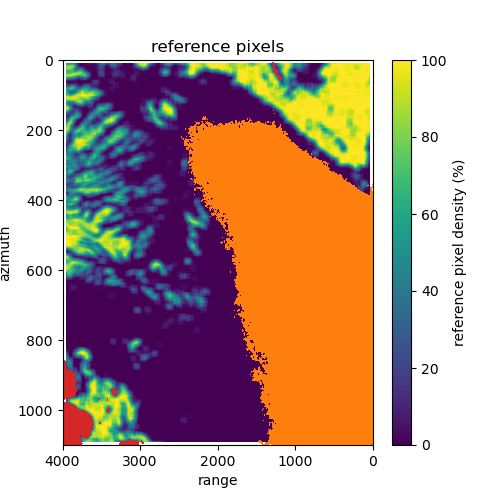

In [11]:
viridis2 = plt.cm.get_cmap("viridis").copy()
viridis2.set_under(color='tab:orange')
viridis2.set_over(color='tab:red')

plt.figure(figsize=(5,5))
plt.imshow(pix_density*100, cmap=viridis2,aspect='auto',interpolation='nearest',vmin=0,vmax=100)
plt.xlim(x1-x2, 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('reference pixels')
plt.colorbar(label='reference pixel density (%)')
plt.show()